<a href="https://colab.research.google.com/github/gagoorisamchon/aalto/blob/main/aifinance_1_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FinanceDataReader를 사용해 상관분석을 시작해 본다.
이 값은 Pearson Correlation Coefficient이다.

먼저 finance-reader를 설치한다.

In [115]:
pip install -q finance-datareader

필요한 모듈을 임포트 한다.

In [116]:
import numpy as np
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt

읽어들일 기간을 설정한다.

In [202]:
start_date ='2019-01-01'
end_date = '2023-12-31'

값을 읽어올 종목의 이름과 심볼 기호를 설정한다.

In [203]:
stocks = ['005930', '066570']
names = ['Samsung', 'LGE']
RISKFREE = 0.01
SCALE_FACTOR = 252

월별 수익률을 기록할 데이터프레임을 선언한다.

In [204]:
WINDOW = 20   # 20 영업일 간격으로 수익률 변화를 계산
df = pd.DataFrame()   # 주가 데이터를 저장할 데이터프레임

주가 중 종가를 읽어 온다.

In [205]:
for stock in stocks:
  df[ stock ] = fdr.DataReader( stock, start_date, end_date ).Close

WINDOW에서 지정한 간격으로 수익률을 계산한 다음, NaN 부분의 행은 모두 삭제한다.

In [206]:
w_ret = df.pct_change(WINDOW).dropna()

가독성을 위해 티커심볼 대신, 회사 이름을 설정한다.

In [207]:
df.columns = names
w_ret.columns = names

corr 메서드를 호출해서 피어슨 상관지수를 구한다.

In [210]:
corr_matrix = w_ret.corr()
print(corr_matrix)

          Samsung       LGE
Samsung  1.000000  0.616252
LGE      0.616252  1.000000


결과로 모든 쌍에 대해 계산된 행렬이 만들어 진다.
이 행렬을 한번 출력해 보자.

# 2개 주식에 대한 샤프지수 확인

샤프함수를 작성한다.

In [188]:
def GetSharpe( d_ret , columns, freq='Y', riskfree=0):
  if freq == 'Y' :  # Annual Sharpe
    a_sharpe = pd.DataFrame()
    a_ret = pd.DataFrame()
    a_std = pd.DataFrame()

    for stock in columns:
      a_ret[stock] = d_ret[stock].resample('Y').mean() * SCALE_FACTOR
      a_std[stock] = d_ret[stock].resample('Y').std()*np.sqrt(SCALE_FACTOR)
      a_sharpe = (a_ret - riskfree) / a_std

    a_sharpe.columns = columns
    return a_sharpe

  elif freq == 'H':   # Historical Sharpe
    # Sharpe from historical data
    avg_ret = np.zeros( len(columns))
    avg_std = np.zeros( len(columns))
    sharpe = np.zeros( len(columns))

    for i, stock in enumerate(columns):
      avg_ret[i] = d_ret[stock].mean() * SCALE_FACTOR
      avg_std[i] = d_ret[stock].std() * np.sqrt(SCALE_FACTOR)
      sharpe[i] = (avg_ret[i] - riskfree)/ avg_std[i]

    return sharpe, avg_ret, avg_std

In [189]:
df = pd.DataFrame()
daily_r = pd.DataFrame()

In [190]:
for stock in stocks:
  df[stock] = fdr.DataReader( stock, start_date, end_date ).Close
  daily_r[stock] = df[stock].pct_change()

In [191]:
df.columns = names
daily_r.columns = names

In [192]:
df.head()

,Samsung,LGE
Date,,
2018-01-02,51020,109500
2018-01-03,51620,109500
2018-01-04,51080,106000
2018-01-05,52120,111000
2018-01-08,52020,105000


In [194]:
df.describe()

,Samsung,LGE
count,1477.000000,1477.000000
mean,60220.548409,98342.044685
std,12676.422785,29589.624878
min,37450.000000,41850.000000
25%,48750.000000,72500.000000
50%,59400.000000,94800.000000
75%,70600.000000,117500.000000
max,91000.000000,185000.000000


In [195]:
daily_r.head()

,Samsung,LGE
Date,,
2018-01-02,NaN,NaN
2018-01-03,0.011760,0.000000
2018-01-04,-0.010461,-0.031963
2018-01-05,0.020360,0.047170
2018-01-08,-0.001919,-0.054054


In [196]:
daily_r.describe()

,Samsung,LGE
count,1476.000000,1476.000000
mean,0.000417,0.000239
std,0.015881,0.024341
min,-0.063877,-0.090625
25%,-0.009738,-0.012923
50%,0.000000,0.000000
75%,0.008625,0.010465
max,0.104706,0.296095


<Axes: xlabel='Date'>

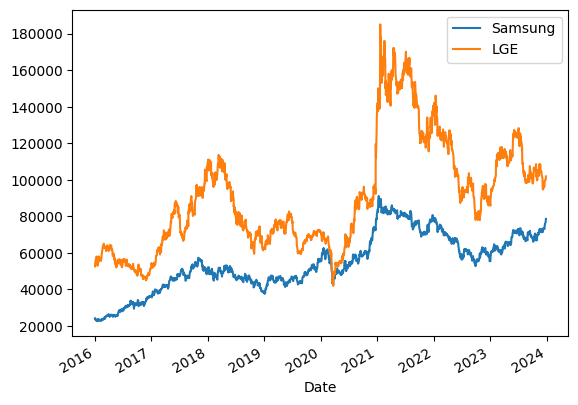

In [166]:
df.plot()

<Axes: xlabel='Date'>

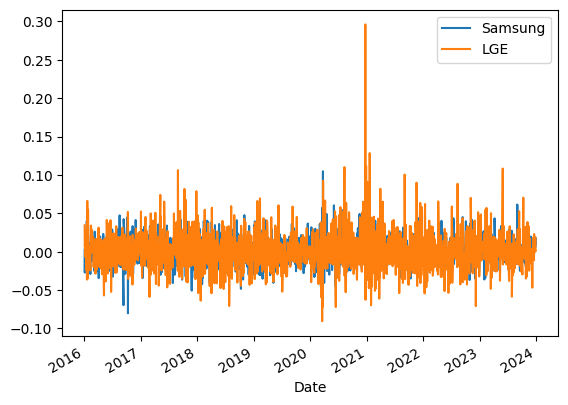

In [167]:
daily_r.plot()

In [168]:
y_sharpe = GetSharpe( daily_r, names, 'Y', RISKFREE)

In [169]:
print(y_sharpe)

             Samsung       LGE
Date                          
2016-12-31  1.649058  0.043789
2017-12-31  1.584925  2.178035
2018-12-31 -0.963762 -1.387550
2019-12-31  1.698989  0.636429
2020-12-31  1.271937  1.455256
2021-12-31 -0.095652  0.247153
2022-12-31 -1.495448 -1.206079
2023-12-31  1.770500  0.669015


In [170]:
y_sharpe.describe()

,Samsung,LGE
count,8.000000,8.000000
mean,0.677568,0.329506
std,1.329446,1.212351
min,-1.495448,-1.387550
25%,-0.312679,-0.268678
50%,1.428431,0.441791
75%,1.661540,0.865575
max,1.770500,2.178035


<Axes: xlabel='Date'>

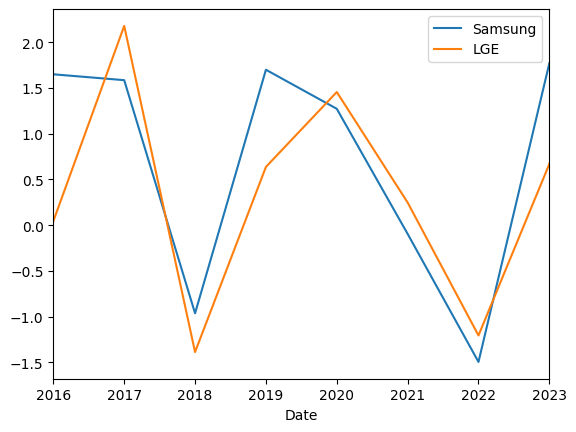

In [171]:
y_sharpe.plot()

In [172]:
h_sharpe, h_ret, h_std = GetSharpe( daily_r, names, 'H', RISKFREE)

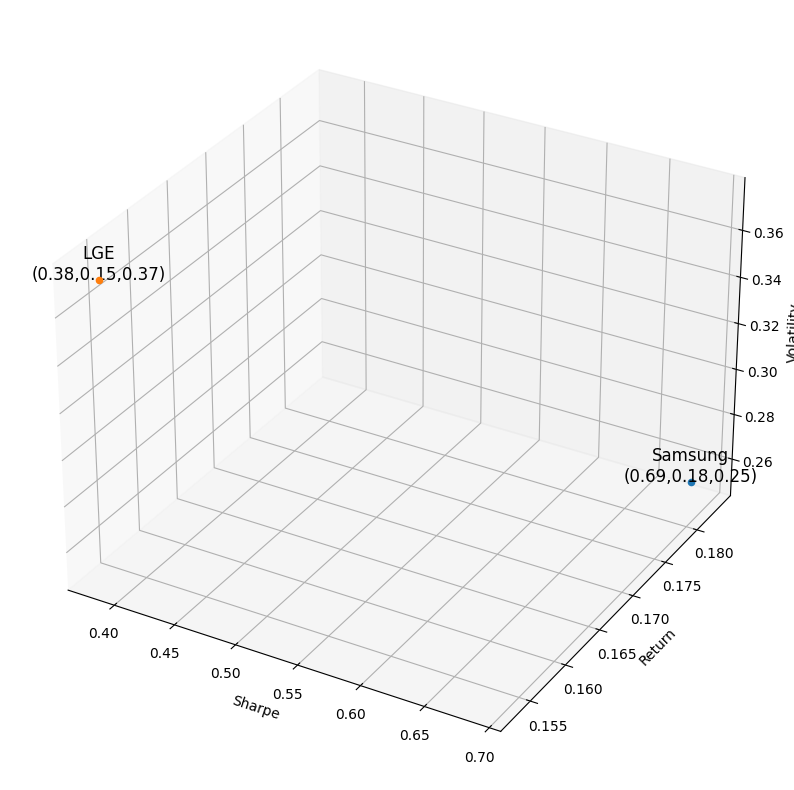

In [173]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 주어진 데이터

# Matplotlib에서 3D 그래프를 그리기 위한 플롯 생성
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 데이터를 3D 공간에 플롯하고 레이블 표시
for i in range(len(names)):
    ax.scatter(h_sharpe[i], h_ret[i], h_std[i], marker='o')
    ax.text(h_sharpe[i], h_ret[i], h_std[i], f"{names[i]}\n({h_sharpe[i]:.2f},{h_ret[i]:.2f},{h_std[i]:.2f})", fontsize=12, ha='center')

# 축 레이블 설정
ax.set_xlabel('Sharpe')
ax.set_ylabel('Return')
ax.set_zlabel('Volatility')


# 그래프 표시
plt.show()

# 2개의 주식을 보유할 경우 최적의 포트폴리오 비율 구성 프로그램

In [197]:
SCALE_FACTOR = 250  # 연환산 계수
NUM_SIMULATION = 20000  # 시뮬레이션 횟수

#종목 시세를 받아올 데이터 프레임을 선언한다.
df = pd.DataFrame()
#주가를 읽어온다.
for stock in stocks:
    df[stock] = fdr.DataReader(stock, '2019-01-01', '2022-12-31').Close

df.columns = names
#일별 수익율을 구한다.
daily_ret = df.pct_change()
#연으로 환산한다.
annual_ret = daily_ret.mean() * SCALE_FACTOR
#모든 주식 조합에 대해 서로 공분산을 구한뒤 이 값도 연환산한다.
daily_cov = daily_ret.cov() # 데이터프레임의 공분산 함수 cov() 이용
annual_cov = daily_cov * SCALE_FACTOR # 연환산

#각 가중치에 대한 포트폴리오의 수익률, 위험, 가중치, 샤프지수를 저장할 배열 선언
port_return = []  # 포트폴리오 수익률
port_risk = []  # 포트폴리오 위험
port_weights = [] # 포트폴리오 가중치
port_sharpe = []  # 포트폴리오 샤프지수

#시뮬레이션 횟수만큼 루프를 돌며, 임의의 가중치에 대해 계산
for i in range(NUM_SIMULATION):
  weights =np.random.random( len(names) ) # 종목만크 임의의 가중치 생성
  weights /= np.sum(weights)  # 가중치의 합은 1이 되도록 조정

  ret = np.dot( weights, annual_ret ) # 현 가중치에 해당하는 포트폴리오 수익률 Rp = SUM( WiRi )
  risk = np.sqrt( np.dot( weights.T, np.dot(annual_cov, weights ) ) ) # 리스크 = SUM(SUM( WiWjCov(i,j)))
  sharpe = ret/risk     # 현 구성에 해당하는 샤프지수 계산
  # 계산한 값들을 배열에 추가
  port_return.append( ret )
  port_risk.append( risk )
  port_sharpe.append( ret / risk )
  port_weights.append( weights )

In [199]:
#배열 전체에서 가장 높은 샤프지수를 가진 index를 찾는다.
max_index = port_sharpe.index(max(port_sharpe))
print(max_index)

9242


In [200]:
#배열 전체에서 가장 낮은 리스크를 가진 index를 찾는다.
min_index = port_risk.index(min(port_risk))
print(min_index)

7310


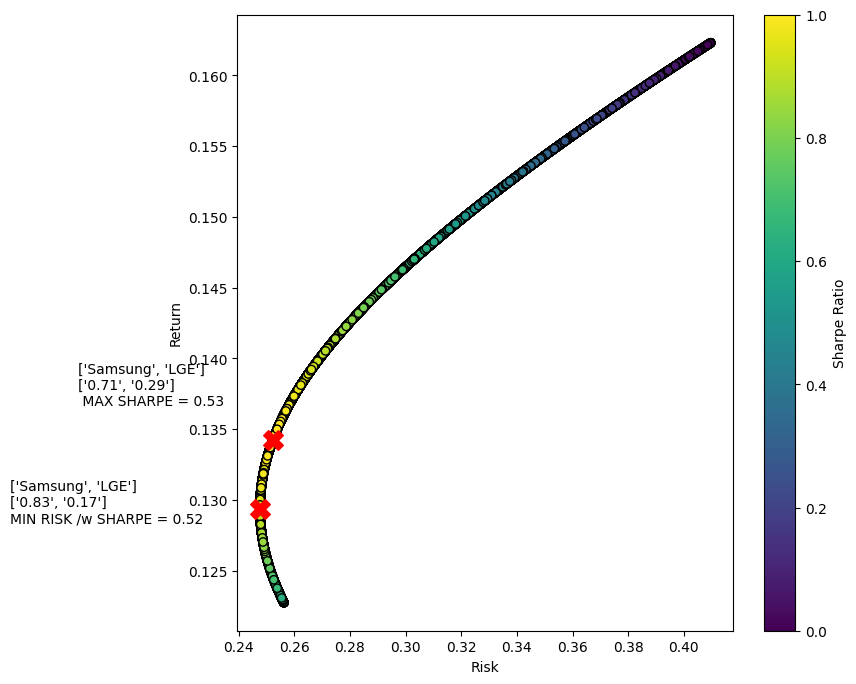

In [201]:
#이제 해당 포트폴리오를 도식화 해 본다.

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
ax = plt.subplot( )

ax.set_xlabel('Risk')
ax.set_ylabel('Return')
plt.scatter( port_risk, port_return, c=port_sharpe, cmap='viridis', edgecolors='k' ) # k는 검은색을 의미한다.

plt.scatter(x=port_risk[max_index], y=port_return[max_index], c='r', marker='X', s=200)
plt.annotate( f'{names}\n{[f"{x:.2f}" for x in port_weights[max_index]]}\n MAX SHARPE = {port_sharpe[max_index]:.2f}', (port_risk[max_index], port_return[max_index]), xytext=(-140,25), textcoords='offset points')

plt.scatter(x=port_risk[min_index], y=port_return[min_index], c='r', marker='X', s=200)
plt.annotate( f'{names}\n{[f"{x:.2f}" for x in port_weights[min_index]]}\nMIN RISK /w SHARPE = {port_sharpe[min_index]:.2f}', (port_risk[min_index], port_return[min_index]), xytext=(-180,-10), textcoords='offset points')

colorbar = plt.colorbar()
colorbar.set_label("Sharpe Ratio")